# scikit-image in segmentation

### 0. Problem statement:
> It is a segmentation problem and the aim is to isolate specific objects from the background in a image.

In [40]:
# Importing libraries
import skimage
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [41]:
# Importing data
from skimage import data
coins = data.coins()

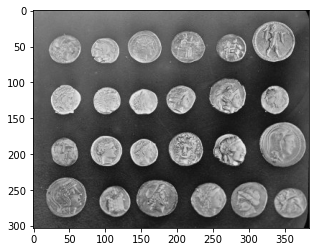

In [42]:
# Data visualization
plt.imshow(coins, cmap='gray')

### 1. Image denoising
> Before any step, we need to do image denoising. On the other words, it is data preprocessing steps.

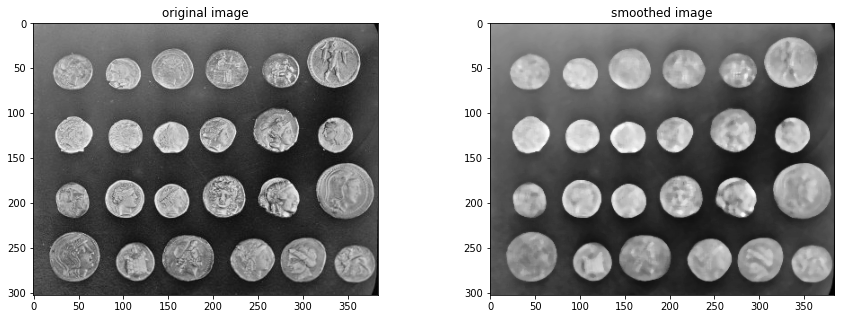

In [72]:
from skimage import filters
# a median filter with size=(5,5)
coins_denoised = filters.median (coins, selem= np.ones((5,5)))

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))

ax0.set_title('original image')
ax0.imshow(coins, cmap = 'gray')

ax1.set_title('smoothed image')
ax1.imshow(coins_denoised, cmap = 'gray')


### 2. Finding edges of objects
> Here canny edge detectore is used to detect pixels associated to edges.

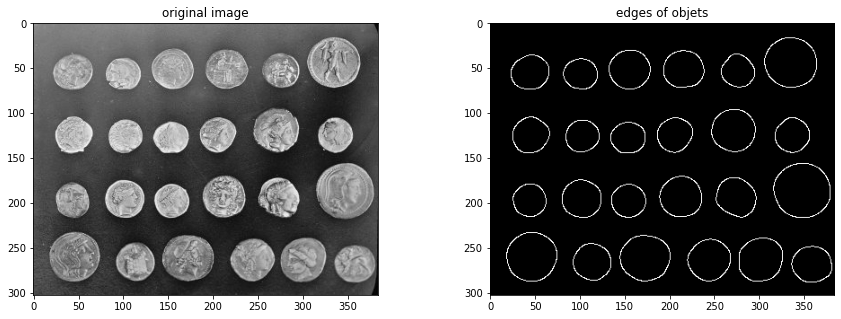

In [71]:
from skimage import feature
# The less the sigma, the more noises
edges = skimage.feature.canny(coins_denoised, sigma = 4)

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))
ax0.set_title('original image')
ax0.imshow(coins, cmap = 'gray')

ax1.set_title('edges of objets')
ax1.imshow(edges, cmap = 'gray')


### 3. Converting image to a distance map
> The boarders/edges just be kept. The main image converted to a map that shows 'how far we are from a coin edge'. As you can see, from the middle of a coin, we are very far away from the edges, and on the edge of the coins we are fairly close to the edge of the coin.

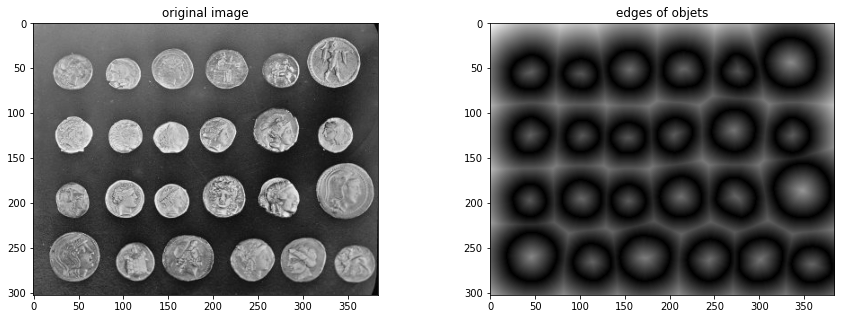

In [69]:
from scipy.ndimage import distance_transform_edt
# distance_transform_edt is a euclidian distance parameter
dt = distance_transform_edt (~edges)

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))
ax0.set_title('original image')
ax0.imshow(coins, cmap = 'gray')

ax1.set_title('edges of objets')
ax1.imshow(dt, cmap = 'gray')

### 4. Finding peaks/features
> Finding the pixels with highest amount helps to find the location of each coin in a image. 

C:\Users\mrb\AppData\Local\Temp/ipykernel_19320/856638078.py:1: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = feature.peak_local_max(dt, indices = False, min_distance = 5)


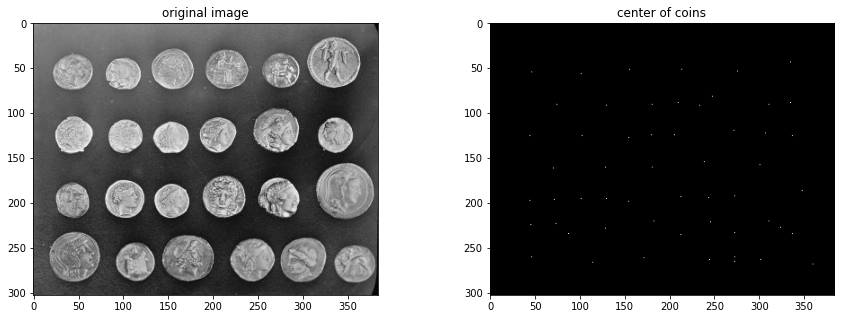

In [118]:
local_max = feature.peak_local_max(dt, indices = False, min_distance = 5)

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))
ax0.set_title('original image')
ax0.imshow(coins, cmap = 'gray')

ax1.set_title('center of coins')
ax1.imshow(local_max, cmap = 'gray')

> Finding the actual positions of peaks/features:

C:\Users\mrb\AppData\Local\Temp/ipykernel_19320/1055456088.py:1: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_idx = feature.peak_local_max(dt, indices = True, min_distance = 5)


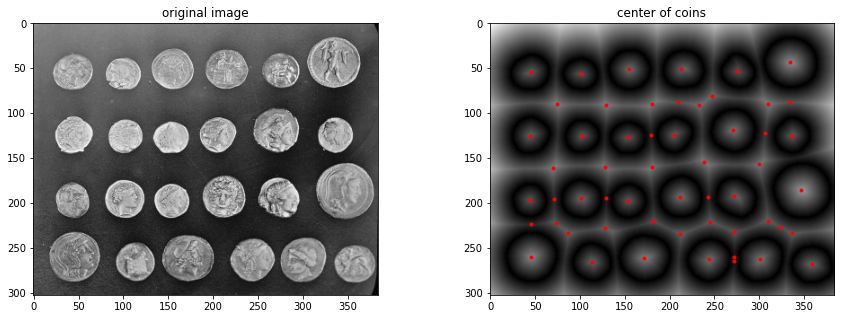

In [79]:
peak_idx = feature.peak_local_max(dt, indices = True, min_distance = 5)
peak_idx[:5]

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))
ax0.set_title('original image')
ax0.imshow(coins, cmap = 'gray')

ax1.set_title('center of coins')
plt.plot(peak_idx[:,1], peak_idx[:,0], 'r.')
ax1.imshow(dt, cmap = 'gray')

### 5. Labeling features
> The regions got a label (a number), this number is used by the watershed to label the regions that form around that fantom.

In [81]:
from skimage import measure
# each dot gets a new integer label
makers = measure.label(local_max)

C:\Users\mrb\AppData\Roaming\Python\Python38\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


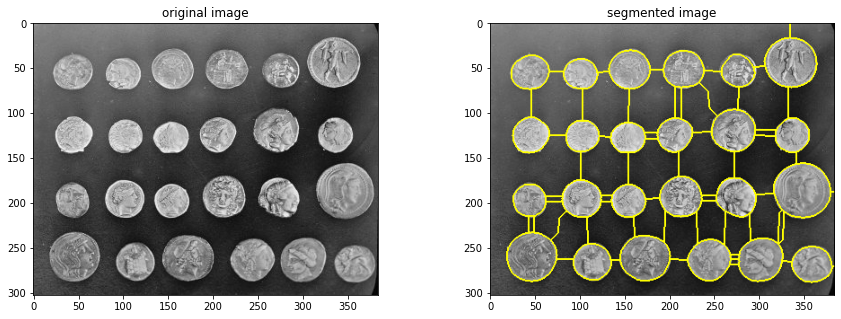

In [114]:
from skimage import morphology, segmentation
# inverting the distance map to a segmented image 
labels = morphology.watershed(-dt, makers)

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))
ax0.set_title('original image')
ax0.imshow(coins, cmap = 'gray')

ax1.set_title('segmented image')
ax1.imshow(segmentation.mark_boundaries(coins, labels), cmap = 'gray')

> segmented image in a slightly different visualization:

C:\Users\mrb\AppData\Local\Temp/ipykernel_19320/458893636.py:7: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  ax1.imshow(color.label2rgb(labels, image=coins))


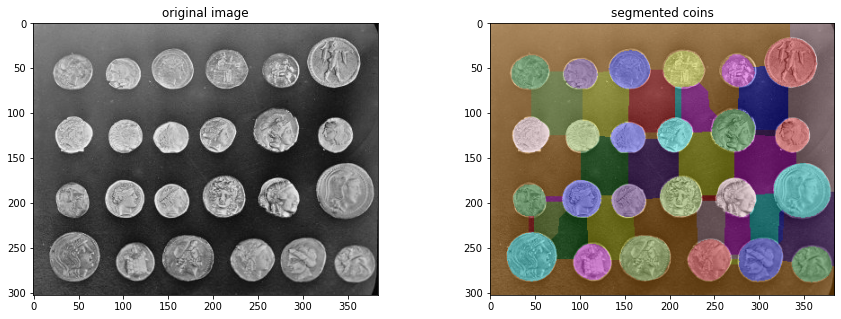

In [117]:
from skimage import color
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))
ax0.set_title('original image')
ax0.imshow(coins, cmap = 'gray')

ax1.set_title('segmented coins')
ax1.imshow(color.label2rgb(labels, image=coins))


### 6. Segmentation
> We should be able to separate the forgrounds and backgrounds by just lookinga at the intensity.

(array([7., 8., 3., 3., 4., 4., 1., 1., 0., 0., 0., 1., 1., 1., 3., 8., 3.,
        3., 1., 3.]),
 array([ 35.34536403,  43.35172328,  51.35808253,  59.36444178,
         67.37080103,  75.37716028,  83.38351953,  91.38987878,
         99.39623803, 107.40259728, 115.40895653, 123.41531578,
        131.42167502, 139.42803427, 147.43439352, 155.44075277,
        163.44711202, 171.45347127, 179.45983052, 187.46618977,
        195.47254902]),
 <BarContainer object of 20 artists>)

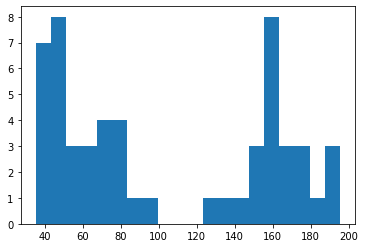

In [105]:
regions = measure.regionprops(labels, intensity_image = coins)
region_means = [r.mean_intensity for r in regions]
plt.hist(region_means, bins=20)

> The graph illustrates a very clear seperation between background (the left objects) and the coins (the right objects associated with the mean intensity of coins). So, if the clusters be splitted with a line around 110, the segmentation would be done.

In [106]:
from sklearn.cluster import KMeans
model = KMeans (n_clusters = 2)

region_means = np.array(region_means).reshape(-1,1)

model.fit(np.array(region_means).reshape(-1,1))
print(model.cluster_centers_)

[[ 57.39241612]
 [163.61541142]]


In [108]:
# labels of forground and background
bg_fg_labels = model.predict(region_means)

> Label the image to the background or forground

C:\Users\mrb\AppData\Local\Temp/ipykernel_19320/2877796497.py:10: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  ax1.imshow(color.label2rgb(classified_labels, image = coins), cmap = 'gray')


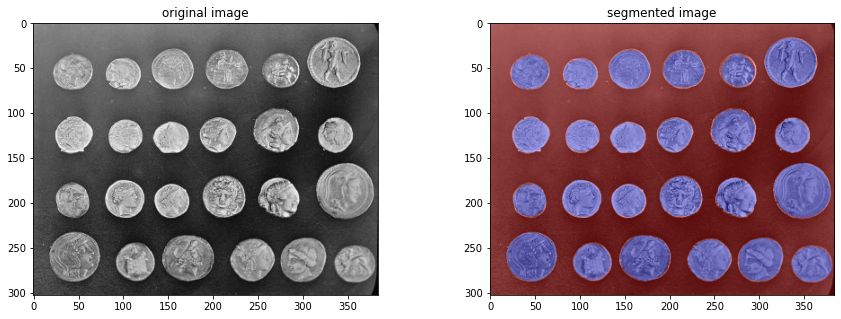

In [113]:
classified_labels = labels.copy()
for bg_fg, region in zip(bg_fg_labels, regions):
    classified_labels[tuple(region.coords.T)] = bg_fg

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))
ax0.set_title('original image')
ax0.imshow(coins, cmap = 'gray')

ax1.set_title('segmented image')
ax1.imshow(color.label2rgb(classified_labels, image = coins), cmap = 'gray')